# MUA spike and feature extractions
-----

Example notebook for multi-unit spike extractions and feature extractions on 
extracellular recordings using Cambridge Neurotech silicon probes in fused organoids. 

**load libraries**

In [1]:
import os
import pathlib 

os.chdir('../..')

from fused_org_ephys import FusedOrgSpikes

## Load metadata
----

First, initialize the ```FusedOrgSpikes``` class and check the metadata of all files wishing to be analysed. 

In all cases, metadata from the recording and tissue culture is attached to each file. For certain information, this is not accessible from the raw files themselves and hence is extracted from a *.csv file which contains information regarding the cell-line information. 

Extra information, such as the organoids age, is computed automatically from the embryoid body and experiment recording dates. In addition, optogenetic and/stimulation times or drug application times are automatically retrieved from the OpenEphys gui message output folder (```.../Message_Center-904.0/TEXT_group_1```).



First, set your path the metadata *.csv. 

In [2]:
metadata_path = pathlib.PurePath('Daniel_SiPro_Data', 'Data', 'fused_org_metadata_test.xlsx')

Next, set the base folder containing all open ephys recording outputs. 

In [3]:
base_folder = 'Daniel_SiPro_Data/Data'

Now, initiate the ```FusedOrgSpikes``` class and check the metadata of the found recordings, along with their metadata.  

In [4]:
mua = FusedOrgSpikes(metadata_path = metadata_path, base_folder=base_folder)

mua.metadata

,index,expID,exp_day,file,EB,condition,left_probe,right_probe,organoid,record_node,...,opto_end_1,ages,1_syncmessage_time,1_syncmessage_txt,2_syncmessage_time,2_syncmessage_txt,3_syncmessage_time,3_syncmessage_txt,4_syncmessage_time,4_syncmessage_txt
0,0,DR0016,2022-11-25,DR016_2022-11-25_20-59-52_64P,2022-06-24,NORMAL,ASSY-77-P-2,None,H9_WT,NaN,...,1200.0,154.0,600.0,baseline_stimulation_start,1200.0,baseline_stimulation_end,NaN,NaN,NaN,NaN
1,1,DR0019,2023-05-06,DR019_2023-05-06_18-43-42,2022-11-25,NORMAL,ASSY-77-P-2,None,H9_WT,103.0,...,1200.0,162.0,600.0,baseline_stimulation_start,1200.0,baseline_stimulation_end,NaN,NaN,NaN,NaN
2,2,DR0022,2023-05-15,DR022_2023-05-15_20-52-41,2022-11-25,NORMAL,ASSY-77-P-2,None,H9_WT,103.0,...,1200.0,171.0,600.0,baseline_stimulation_start,1200.0,baseline_stimulation_end,1200.0,synaptic_cocktail,1500.0,synaptic_cocktail_stimulation_start


Cross-check that the correct file paths were found for each recording. 

In [5]:
mua.file_path_info['file_paths']

[PurePosixPath('Daniel_SiPro_Data/Data/DR016_2022-11-25_20-59-52_64P/experiment1/recording2/continuous/Channel_Map-101_100.0/continuous.dat'),
 PurePosixPath('Daniel_SiPro_Data/Data/DR019_2023-05-06_18-43-42/Record Node 103/experiment1/recording1/continuous/Intan_Rec._Controller-100.0/continuous.dat'),
 PurePosixPath('Daniel_SiPro_Data/Data/DR022_2023-05-15_20-52-41/Record Node 103/experiment1/recording1/continuous/Intan_Rec._Controller-100.0/continuous.dat')]

## Multi-unit spike extraction
-----

Initialize the ```FusedOrgEphys``` class. 

Set the path to metadata file, and base folder containing extracellular recordings from the OpeEphys GUI (as shown above). 

Next, select the ```expID``` of the organoid recording for analysis. 

NOTE: entire recordings were analysed and extracted for the paper. However, time ranges can be set for processing using ```time_range```. An example is shown below. 

In [6]:
mua = FusedOrgSpikes(metadata_path = metadata_path, expID=['DR0022'], time_range = [0,1250], base_folder='Daniel_SiPro_Data/Data')

                🧠 ORGANOID OPENEPHYS LOADER OVERVIEW 🧠                
                                  
                                   
File path : Daniel_SiPro_Data/Data/DR022_2023-05-15_20-52-41/Record Node 103/experiment1/recording1/continuous/Intan_Rec._Controller-100.0/continuous.dat
                  Loading *.dat file from file path                   
                                  
                                   
                       Left probe : ASSY-77-P-2                       
                          Right probe : None                          
                     Left & right probe selection                     
                                  
                                   
                        Channel id length : 67                        
                    Initial number of channel IDs                     
                                  
                                   
                     Post-QC channels removed : 4                

Save the mua spike array into the ```save_folder```.

In [7]:
expID = mua.metadata['expID'].values[0] # find expID
fname = expID + '_mua_spikes_test' # create filename

mua.save_muaspikes(fname=fname)

The directory already exists for Daniel_SiPro_Data/Data/Processed/revision2/muaspikes/
saving to: Daniel_SiPro_Data/Data/Processed/revision2/muaspikes/DR0022_mua_spikes_test.pkl
saved


Alternatively, if a pickled mua spike array was previously processed and saved using the ```group_save_muaspikearr``` module. This can be directly opened, as shown below by parsing a file path to the file in ```spikearr_fpath```.

In [5]:
mua = FusedOrgSpikes(spikearr_fpath = 'Daniel_SiPro_Data/Data/Processed/revision2/muaspikes/DR0022_mua_spikes_test.pkl')

loading Daniel_SiPro_Data/Data/Processed/revision2/muaspikes/DR0022_mua_spikes_test.pkl


## Multi-unit spike analysis
-----


#### **Filter for active channels**


Actve channels are determined across optogenetic stimulation segments at baseline (no drugs), and must have > 50 spks (5 spks/min) over 10-minutes. 

In [6]:
baseline_opto_start = mua.metadata['1_syncmessage_time'].values[0]
stim_length = 10*60

print(f'baseline opto start: {baseline_opto_start}')

mua.set_activechannels(spk_activechan_interval = [baseline_opto_start, baseline_opto_start+stim_length], spk_count_thresh = 50)

baseline opto start: 602.645
filter channels with >= 5.0 spks/min | time interval [602.645, 1202.645] seconds


### Set optogetnetic parameters
----

First, set this at baseline periods. 

In [7]:
train_dur = stim_length # length of optogenetic stimulus
interval = 10 # pulse interval in ms
dur = 0.5 # pulse duration in ms

mua.set_baseline_optostim(start=baseline_opto_start, train_dur=train_dur, interval=interval, dur=dur)

If applicable, repeat this for drug applications. If not, this skipped was skipped. 

In [8]:
baseline_opto_end = mua.metadata.opto_end_1.values[0]
mua.set_drug_optostim(start=baseline_opto_end, train_dur=train_dur, interval=interval, dur=dur)

#### **Return mean firing rate changes**

Return a dataframe with mean firing rate changes, along with file metadata. 

This output can be used to compare the mean firing rates of different organoids pre- and post-optogenetic conditions. 

Save the dataframe to the ```save_folder```. File name is set as the expID. 

In [9]:
mfr_df = mua.return_mfr_df(time_window=600, save_folder = 'Daniel_SiPro_Data/Data/Processed/revision2/dataframes/')
mfr_df

The directory already exists for Daniel_SiPro_Data/Data/Processed/revision2/dataframes/
saving to: Daniel_SiPro_Data/Data/Processed/revision2/dataframes/mfr_df_DR022_2023-05-15_20-52-41.xlsx
saved


,expID,exp_day,file,EB,organoid,ages,optostim_region,probe_region,chans,number_chans,...,mfr,mfr_opto,mfr_activechans,mfr_opto_activechans,mfr_perchan,mfr_opto_perchan,mfr_activechans_perchan,mfr_opto_activechans_perchan,responding_activechans,total_activechans
file,,,,,,,,,,,,,,,,,,,,,
DR022_2023-05-15_20-52-41,DR0022,2023-05-15,DR022_2023-05-15_20-52-41,2022-11-25,H9_WT,171.0,vmid,cortical,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",63,...,0.514735,3.13037,0.514735,3.13037,"[0.25, 0.03833333333333333, 0.055, 0.0, 0.06, ...","[2.2783333333333333, 3.01, 3.0866666666666664,...","[0.25, 0.03833333333333333, 0.055, 0.0, 0.06, ...","[2.2783333333333333, 3.01, 3.0866666666666664,...",55,63


Check key values such as mean firing rates at baseline vs optogenetic stimulation periods. 

In [10]:
mfr_baseline = mfr_df.mfr.values[0]
mfr_opto = mfr_df.mfr_opto.values[0]

print(f'mfr at baseline: {mfr_baseline} Hz | mfr during opto: {mfr_opto} Hz | change pre-post: {mfr_opto/mfr_baseline*100:.2f}%')

mfr at baseline: 0.5147354497354497 Hz | mfr during opto: 3.13037037037037 Hz | change pre-post: 608.15%


## Visualizations
-----

Visualize rasterplot, split across multiple shanks, with optogenetic stimulation tags.

First, generate and set the network event vector. 

In [11]:
mua.set_network_event

generating network event vector using active channels


Next, plot the rasterplot for a given xlim. Here, we have isolated the period +/- 100 seconds around the first optostimulation pulse. 

In [12]:
opto_text_1 = mua.metadata['1_syncmessage_txt'].values[0]
opto_time_1 = mua.metadata['1_syncmessage_time'].values[0]
expID = mua.metadata['file'].values[0]

print(f'{opto_text_1} at stimulation time: {opto_time_1} seconds, in expID: {expID}')

baseline_stimulation_start at stimulation time: 600.0 seconds, in expID: DR022_2023-05-15_20-52-41


plotting opto raster with active channels


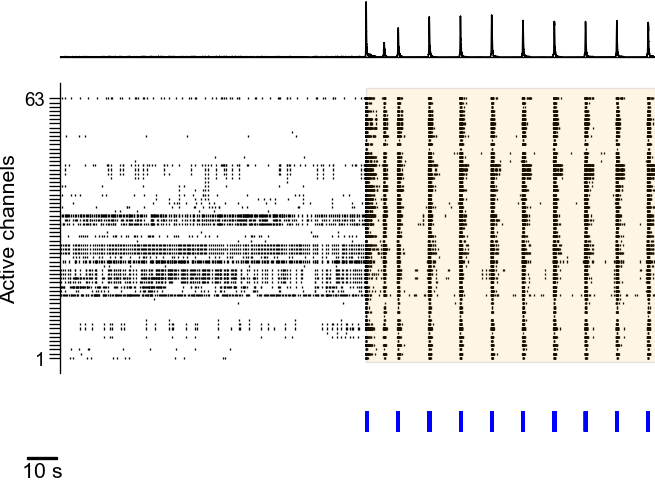

In [13]:
mua.opto_rasterplot(xlim = [opto_time_1-100, opto_time_1+100])